<a href="https://colab.research.google.com/github/informatics-isi-edu/facebase-ml-exec/blob/main/notebooks/VGG19_Diagnosis_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 

This notebook applied a pre-trained model to a dataset specified in the configuration file and uploads the labels to the catalog.  The ROC curve is also calculated and uploaded.

In [1]:
repo_dir = "Repos"   # Set this to be where your github repos are located.
%load_ext autoreload
%autoreload 2

# Update the load path so python can find modules for the model
import sys
from pathlib import Path
sys.path.insert(0, str(Path.home() / repo_dir / "facebase-ml"))

In [2]:
import json
import os
from facebase_ml.facebase_ml import FaceBaseML
import pandas as pd
from pathlib import Path, PurePath
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True)

2024-05-01 23:52:49.423789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 23:52:51.692919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from deriva.core.utils.globus_auth_utils import GlobusNativeLogin
catalog_id = "fb-ml" #@param
host = 'ml.facebase.org'


gnl = GlobusNativeLogin(host=host)
if gnl.is_logged_in([host]):
    print("You are already logged in.")
else:
    gnl.login([host], no_local_server=True, no_browser=True, refresh_tokens=True, update_bdbag_keychain=True)
    print("Login Successful")

2024-05-01 23:52:53,970 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-05-01 23:52:53,971 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


You are already logged in.


Connect to Eye-AI catalog.  Configure to store data local cache and working directories.  Initialize Eye-AI for pending execution based on the provided configuration file.

In [4]:
# Variables to configure the rest of the notebook.

cache_dir = '/data'        # Directory in which to cache materialized BDBags for datasets
working_dir = '/data'    # Directory in which to place output files for later upload.
# Change to your username on the VM

configuration_rid="58-TW70"      # Configuration file for this run.  Needs to be changed for each execution.

In [5]:
FB = FaceBaseML(hostname = host, catalog_id = catalog_id, cache_dir= cache_dir, working_dir=working_dir)
print(f" Initializing model version: {FB.version}")

2024-05-01 23:52:54,042 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-05-01 23:52:54,043 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


 Initializing model version: 1.1.0.post4+git.7705a472


In [6]:
# @title Initiate an Execution
configuration_records = FB.execution_init(configuration_rid=configuration_rid)
input_dataset = configuration_records.bag_paths[0] # Assumes that the configuration file only specifies one dataset.
configuration_records.model_dump()

2024-05-01 23:52:56,185 - INFO - File [/data/maryamahmadii/FaceBaseML_working/Execution_Metadata/Execution_Config-MusMorph_train_10pct.json] transfer successful. 0.74 KB transferred. Elapsed time: 0:00:00.000080.
2024-05-01 23:52:56,185 - INFO - Verifying MD5 checksum for downloaded file [/data/maryamahmadii/FaceBaseML_working/Execution_Metadata/Execution_Config-MusMorph_train_10pct.json]
2024-05-01 23:52:56,201 - INFO - Configuration validation successful!


{'caching_dir': PosixPath('/data'),
 'working_dir': PosixPath('/data/maryamahmadii/FaceBaseML_working'),
 'vocabs': {'Workflow_Type': [{'name': 'Model Training', 'rid': '58-TC9E'}],
  'Execution_Asset_Type': [{'name': 'Model', 'rid': '58-TC9G'}]},
 'execution_rid': '58-TWK8',
 'workflow_rid': '58-TC9M',
 'bag_paths': [PosixPath('/data/58-TC6A_dbe4619ed2511dd8fae878901edefa38419604b264c4c5d3ad32e9d3c5f5944c/Dataset_58-TC6A'),
  PosixPath('/data/58-TCBG_c602a1818329e7ccc455c931f92b767b57e796e6e6ffda510f18f98e6ebf8d9c/Dataset_58-TCBG'),
  PosixPath('/data/58-TCBR_076bc7f6a9e2ee7dad26971e52af4daf36fef312384a327e0368dbfdd1f5ecae/Dataset_58-TCBR')],
 'assets_paths': [],
 'configuration_path': PosixPath('/data/maryamahmadii/FaceBaseML_working/Execution_Metadata/Execution_Config-MusMorph_train_10pct.json')}

In [7]:
train_base_dir = configuration_records.bag_paths[0]
valid_base_dir = configuration_records.bag_paths[1]
test_base_dir = configuration_records.bag_paths[2]

biosample_filename = 'data/biosample.csv'
genotype_filename = 'data/genotype.csv'
Train_output_filename = FB.working_dir/'Train_mapped_file.csv'
Val_output_filename = FB.working_dir/'Val_mapped_file.csv'
Test_output_filename = FB.working_dir/'Test_mapped_file.csv'


Train_df, Train_mapped_file = FB.join_and_save_csv(train_base_dir, biosample_filename, genotype_filename, Train_output_filename)
Val_df, Val_mapped_file = FB.join_and_save_csv(valid_base_dir, biosample_filename, genotype_filename, Val_output_filename)
Test_df, Test_mapped_file = FB.join_and_save_csv(test_base_dir, biosample_filename, genotype_filename, Test_output_filename)


In [8]:
# Prepare datasets
FB = FaceBaseML()

csv_path = Train_mapped_file
images_folder_path = train_base_dir.joinpath('data/assets/Image')
image_paths, labels = FB.load_images_and_labels(csv_path, images_folder_path)
train_dataset = FB.prepare_dataset(image_paths, labels, batch_size=10, shuffle=False, augment_type= None)

csv_path = Val_mapped_file
images_folder_path = valid_base_dir.joinpath('data/assets/Image')
image_paths, labels = FB.load_images_and_labels(csv_path, images_folder_path)
validation_dataset = FB.prepare_dataset(image_paths, labels, batch_size=10, shuffle=False, augment_type= None)

csv_path = Test_mapped_file
images_folder_path = test_base_dir.joinpath('data/assets/Image')
image_paths, labels = FB.load_images_and_labels(csv_path, images_folder_path)
test_dataset = FB.prepare_dataset(image_paths, labels, batch_size=10, shuffle=False, augment_type= None)


2024-05-01 23:53:00,435 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-05-01 23:53:00,436 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>
2024-05-01 23:53:00.962196: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 23:53:01.488273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-

### Go to training process, This is just to check if images and labels have been loaded correctly

In [10]:
for images, labels in validation_dataset.take(1):
    print("Images shape:", images.shape) 
    print("Labels shape:", labels.shape)
    print("Images dtype:", images.dtype)
    print("Labels dtype:", labels.dtype)


/home/maryamahmadii/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')


Images shape: (10, 128, 128, 128, 1)
Labels shape: (10,)
Images dtype: <dtype: 'float32'>
Labels dtype: <dtype: 'int32'>


2024-05-01 18:03:12.567500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
# Iterating through the dataset to count actual images
num_images = 0
for images, labels in test_dataset.unbatch():
    num_images += 1

print("Total number of images in test_dataset:", num_images)


Total number of images in test_dataset: 116


2024-05-01 18:10:34.927606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training process starts here

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the base directory where the model checkpoints should be saved
base_dir = '/data/maryamahmadii/FaceBaseML_working'

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Define ModelCheckpoint
model_checkpoint = ModelCheckpoint(filepath=base_dir + '/best_model.keras', save_best_only=True)


In [10]:
FB.build_3d_cnn_model()

history = FB.ml_model.fit(
    x=train_dataset,  
    validation_data=validation_dataset, 
    epochs=5,
    batch_size=2,
    callbacks=[early_stopping, model_checkpoint]
)


2024-05-01 23:53:38,224 - INFO - Creating client of type <class 'globus_sdk.services.auth.client.native_client.NativeAppAuthClient'> for service "auth"
2024-05-01 23:53:38,225 - INFO - Finished initializing AuthLoginClient. client_id='8ef15ba9-2b4a-469c-a163-7fd910c9d111', type(authorizer)=<class 'globus_sdk.authorizers.base.NullAuthorizer'>


Epoch 1/5


/home/maryamahmadii/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')
I0000 00:00:1714607677.356772    5926 service.cc:145] XLA service 0x7ff0a4004c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714607677.356846    5926 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-05-01 23:54:37.673130: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-01 23:54:38.591733: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-05-01 23:54:46.485256: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=8,k3=0} for conv (f32[16,1,3,3,3]{4,3,2,1,0}, 

 1/38 ━━━━━━━━━━━━━━━━━━━━ 45:49 74s/step - accuracy: 0.9000 - loss: 0.6835

I0000 00:00:1714607692.959260    5926 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 1649s 43s/step - accuracy: 0.7564 - loss: 0.5546 - val_accuracy: 0.9355 - val_loss: 0.2774
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1698s 44s/step - accuracy: 0.8245 - loss: 0.5277 - val_accuracy: 0.9355 - val_loss: 0.3257
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1639s 43s/step - accuracy: 0.8245 - loss: 0.4975 - val_accuracy: 0.9355 - val_loss: 0.2472
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1651s 43s/step - accuracy: 0.8245 - loss: 0.5342 - val_accuracy: 0.9355 - val_loss: 0.2388
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 1657s 43s/step - accuracy: 0.8245 - loss: 0.5394 - val_accuracy: 0.9355 - val_loss: 0.2462


2024-05-02 02:14:31,614 - INFO - generated new fontManager


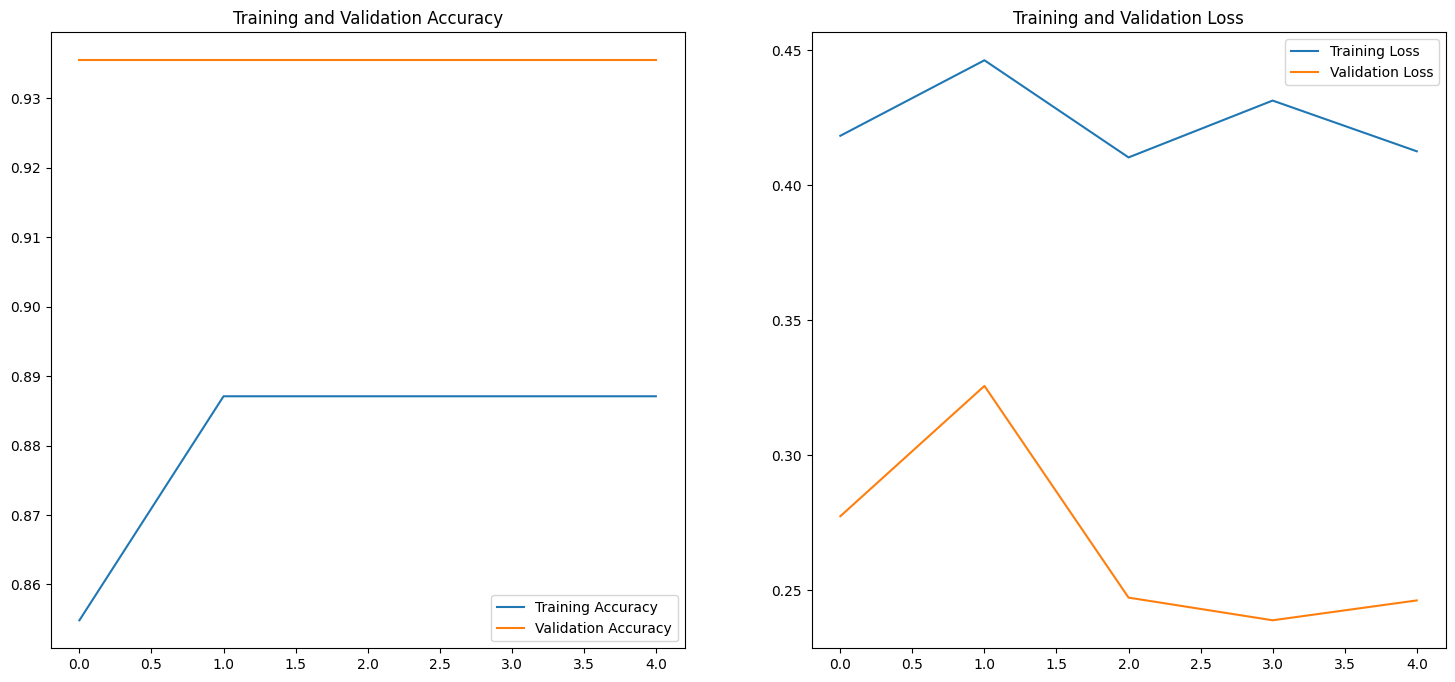

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(acc)
epochs_range = range(epochs)
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Kernel died again after second epoch so load model again for test dataset

In [16]:
from tensorflow.keras.models import load_model
#base_dir = '/data/maryamahmadii/FaceBaseML_working'
#checkpoint_path = base_dir + '/best_model.keras'

try:
    model = load_model(base_dir + '/best_model.keras')
    print("Checkpoint loaded successfully.")
except Exception as e:
    print("Error loading checkpoint:", str(e))


Checkpoint loaded successfully.


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 126, 126, 126,  │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 63, 63, 63, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 61, 61, 61, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 30, 30, 30, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 28, 28, 28, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 14, 14, 14, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 12,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 4, 4, 4, 256)   │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 2, 2, 2, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,676,709 (25.47 MB)

 Trainable params: 2,225,569 (8.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,451,140 (16.98 MB)

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


/home/maryamahmadii/.conda/envs/my-tensorflow-conda/lib/python3.10/site-packages/nibabel/minc2.py:68: UserWarning: Invalid spacing declaration: b'xspace'; assuming regular
  warnings.warn(f'Invalid spacing declaration: {spacing}; assuming regular')


12/12 ━━━━━━━━━━━━━━━━━━━━ 417s 33s/step - accuracy: 0.8195 - loss: 0.5324
Test Loss: 0.3154839873313904, Test Accuracy: 0.9051724076271057


Algorithm was trained on cropped images, so take the raw images and bounding boxes and apply, storing the results in the working directory.

Import the actual model code and then run against the input dataset specified in the configuration file.  

In [ ]:
# @title Execute Proecss algorithm (Test model)
from facebase_ml_tools.models.some_file import #some model

with FB.execution(execution_rid=configuration_records.execution_rid) as exec:
  output_path = FB.execution_assets_path/Path("Model_Prediction")


In [ ]:
# @title Plot ROC.


Add the new lables to the catalog using the provided diagnosis tage for this execution.  Also upload any additional assets that were produced by this execution..

In [ ]:
# @title Save Diagnosis


In [ ]:
# @title Save Execution Assets (model) and Metadata
uploaded_assets = FB.execution_upload(configuration_records.execution_rid, False)
